# Install Dependendcies

In [ ]:
!pip3 install transformers

     |████████████████████████████████| 3.5 MB 4.9 MB/s 
     |████████████████████████████████| 67 kB 2.6 MB/s 
     |████████████████████████████████| 6.5 MB 45.9 MB/s 
     |████████████████████████████████| 895 kB 45.8 MB/s 
     |████████████████████████████████| 596 kB 60.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!nvidia-smi

Wed Mar  2 21:55:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import drive 
# drive.mount('/content/gdrive')
# !ln -s /content/gdrive/My\ Drive/ /mydrive
# !ls /mydrive

# Download the Dataset

In [ ]:
!gdown --id 1-n9aJG1zdWHL0UjuRWwa8Rro-ogoWxN7
!unzip deception_dataset.zip && rm deception_dataset.zip && rm -r __MACOSX

Streaming output truncated to the last 5000 lines.
  inflating: deception_dataset/restaurant/deceptive_MTurk/85.txt  
  inflating: __MACOSX/deception_dataset/restaurant/deceptive_MTurk/._85.txt  
  inflating: deception_dataset/restaurant/deceptive_MTurk/153.txt  
  inflating: __MACOSX/deception_dataset/restaurant/deceptive_MTurk/._153.txt  
  inflating: deception_dataset/restaurant/deceptive_MTurk/147.txt  
  inflating: __MACOSX/deception_dataset/restaurant/deceptive_MTurk/._147.txt  
  inflating: deception_dataset/restaurant/deceptive_MTurk/146.txt  
  inflating: __MACOSX/deception_dataset/restaurant/deceptive_MTurk/._146.txt  
  inflating: deception_dataset/restaurant/deceptive_MTurk/152.txt  
  inflating: __MACOSX/deception_dataset/restaurant/deceptive_MTurk/._152.txt  
  inflating: deception_dataset/restaurant/deceptive_MTurk/84.txt  
  inflating: __MACOSX/deception_dataset/restaurant/deceptive_MTurk/._84.txt  
  inflating: deception_dataset/restaurant/deceptive_MTurk/90.txt  
  in

# Data Helpers

In [ ]:
import numpy as np
import string
import os
import io
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

SEQUENCE_LEN = 200


def read_from_dir(in_fold_dir):
    reviews = []
    for filename in os.listdir(in_fold_dir):
        if filename.endswith(".txt"):
            # read from file containing the text review
            in_filepath = in_fold_dir + filename
            with io.open(in_filepath, 'r', encoding='windows-1252') as f:
                review = f.read()
                # if len(review) > SEQUENCE_LEN:
                #     review = review[:200]
                reviews.append(review)    

    # print("number of reviews: {}, name: {}".format(len(reviews), in_fold_dir)) 
    print(reviews[:2])         
    return reviews


def load_data():
    trustworthy_hotel_positive = read_from_dir('deception_dataset/hotel/positive/truthful/') 
    trustworthy_hotel_negative = read_from_dir('deception_dataset/hotel/negative/truthful/')
    trustworthy_restaurant = read_from_dir('deception_dataset/restaurant/truthful/')
    trustworthy_doctor = read_from_dir('deception_dataset/doctor/truthful/')[:200]

    untrustworthy_hotel_positive = read_from_dir('deception_dataset/hotel/positive/deceptive_turker/')
    untrustworthy_hotel_negative = read_from_dir('deception_dataset/hotel/negative/deceptive_turker/') 
    untrustworthy_hotel_expert_positive =  read_from_dir('deception_dataset/hotel/positive/deceptive_expert/')
    untrustworthy_hotel_expert_negative =  read_from_dir('deception_dataset/hotel/negative/deceptive_expert/')
    
    untrustworthy_restaurant = read_from_dir('deception_dataset/restaurant/deceptive_MTurk/')[:200]
    untrustworthy_doctor = read_from_dir('deception_dataset/doctor/deceptive_MTurk/')

    TRUSTWORTHY_REVIEWS_DICT = {}
    UNTRUSTWORTHY_REVIEWS_DICT = {}

    TRUSTWORTHY_REVIEWS_DICT["cross_domain"] = {
        "hotel":trustworthy_hotel_positive + trustworthy_hotel_negative,
        "restaurant":trustworthy_restaurant,
        "doctor":trustworthy_doctor
    }

    UNTRUSTWORTHY_REVIEWS_DICT["cross_domain"] = { 
        "hotel":untrustworthy_hotel_positive + untrustworthy_hotel_negative,
        "restaurant":untrustworthy_restaurant,
        "doctor":untrustworthy_doctor[:200]
    }

    TRUSTWORTHY_REVIEWS_DICT["mixed_domain"] = {
        "hotel":trustworthy_hotel_positive + trustworthy_hotel_negative,
        "restaurant":trustworthy_restaurant,
        "doctor":trustworthy_doctor
    }

    UNTRUSTWORTHY_REVIEWS_DICT["mixed_domain"] = { 
        "hotel":untrustworthy_hotel_positive + untrustworthy_hotel_expert_positive + untrustworthy_hotel_negative + untrustworthy_hotel_expert_negative,
        "restaurant":untrustworthy_restaurant,
        "doctor":untrustworthy_doctor
    }

    return TRUSTWORTHY_REVIEWS_DICT, UNTRUSTWORTHY_REVIEWS_DICT


TRUSTWORTHY_REVIEWS_DICT, UNTRUSTWORTHY_REVIEWS_DICT = load_data()

['I booked this hotel for $75 on Hotwire with mid-level expectations for one night. Totally blown away. Arrived on a Sunday night. Gave car to valet ($51/night). Lobby was a social people watching scene with swank music. Check-in was smooth and easy. I asked for an upgrade and was told no free upgrades to 3rd party bookings. Upgrade to suite was available at a cost. I passed since only 1 night stay. I asked for a nice, quiet room away from noisy housekeeping and ice machine. Received room 10-120. Room was huge with 2 beds. Felt like 400 square feet. Newly renovated last year. Bell hop told me some rooms are very small so I totally lucked out! Service from start to finish was top notch. Everyone had a smile on their face. Always spoke with great respect and made us feel welcome. Ordered room service at 10:45 PM. Arrived in 1/2 hour. food was so-so. Had pancakes in Lockwood for breakfast. Very good food and very good service. Strong coffee. Hotel is right on State Street shopping. FYI - 

In [ ]:
def get_reviews_from_dict(reviews_dict, keys = []):
    if not keys:
        raise Exception("Invalid key: key must be one of the following: \'hotel\', \'restaurant\', \'doctor\'")

    reviews = []
    for key in keys:
        if key in reviews_dict:
            reviews += reviews_dict[key]
        else:
            raise Exception("Invalid key: key must be one of the following: \'hotel\', \'restaurant\', \'doctor\'")
    return reviews

def get_reviews(review_type="", keys = [], data_name="cross_domain"):
    if not review_type:
        raise Exception("Invalid review_type: review_type must be either \'trustworthy\' or \'untrustworthy\'.")
    if not keys:
        raise Exception("Invalid key: key must be one of the follwowing: \'hotel\', \'restaurant\', \'doctor\'")

    if review_type=="trustworthy":
        return get_reviews_from_dict(reviews_dict=TRUSTWORTHY_REVIEWS_DICT[data_name], keys=keys)
    elif review_type=="untrustworthy":
        return get_reviews_from_dict(reviews_dict=UNTRUSTWORTHY_REVIEWS_DICT[data_name], keys=keys)
    else:
        raise Exception("Invalid review_type: review_type must be either \'trustworthy\' or \'untrustworthy\'.")


def get_data(keys=[], data_name="cross_domain"):
    if data_name != "cross_domain" and data_name != "mixed_domain":
        raise Exception("Invalid dataset name")

    trustworthy_reviews   = get_reviews(review_type="trustworthy", keys=keys, data_name=data_name)
    untrustworthy_reviews = get_reviews(review_type="untrustworthy", keys=keys, data_name=data_name)
    
    reviews = trustworthy_reviews + untrustworthy_reviews

    # generate labels
    labels_trustworthy   = [[1,0] for _ in range(len(trustworthy_reviews   ))]
    labels_untrustworthy = [[0,1] for _ in range(len(untrustworthy_reviews ))]
    labels = labels_trustworthy + labels_untrustworthy

    print("dataset_name: {}".format(data_name+"_"+keys[0]))
    print("trustworthy_reviews: {}".format(len(trustworthy_reviews)))
    print("untrustworthy_reviews: {}".format(len(untrustworthy_reviews)))
    print("reviews len: ", len(reviews))
    print("labels len: ", len(labels))
    print()
        
    return reviews, labels

In [ ]:
import numpy as np
import os
import re
import itertools
import scipy.sparse as sp
from collections import Counter
import torch


SEQUENCE_LEN = 200


def build_vocab(sentences, vocab_size=50000):
    word_counts = Counter(itertools.chain(*sentences)) 
    vocabulary_inv = [x[0] for x in word_counts.most_common(vocab_size)]
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    # append <UNK/> symbol to the vocabulary
    vocabulary['<UNK/>'] = len(vocabulary)
    vocabulary_inv.append('<UNK/>')
    return [vocabulary, vocabulary_inv]


def build_input_data(sentences, vocabulary):
    x = np.array([[vocabulary[word] if word in vocabulary else vocabulary['<UNK/>'] for word in sentence] for sentence in sentences])
    return x


def load_data(fold = 1, vocab_size=30001):
    # Load data
    trustworthy_reviews_for_training, trustworthy_reviews_for_testing, untrustworthy_reviews_for_training, untrustworthy_reviews_for_testing = data.load_data(fold=fold)
    train = trustworthy_reviews_for_training + untrustworthy_reviews_for_training
    test  = trustworthy_reviews_for_testing + untrustworthy_reviews_for_testing

    # generate labels
    train_labels1 = [[1,0] for _ in range(len(trustworthy_reviews_for_training   ))]
    train_labels0 = [[0,1] for _ in range(len(untrustworthy_reviews_for_training ))]
    test_labels1  = [[1,0] for _ in range(len(trustworthy_reviews_for_testing    ))]
    test_labels0  = [[0,1] for _ in range(len(untrustworthy_reviews_for_testing  ))]

    train_labels = np.concatenate((np.array(train_labels1), np.array(train_labels0)), axis=0)
    test_labels  = np.concatenate((np.array(test_labels1),  np.array(test_labels0)),  axis=0)

    # convert word2idx
    vocabulary, vocabulary_inv = build_vocab(train + test, vocab_size=vocab_size)
    train = build_input_data(train, vocabulary)
    test  = build_input_data(test,   vocabulary)
    
    return train, train_labels, train_labels, train, test_labels, test_labels, vocabulary, vocabulary_inv


def batch_iter(data, batch_size, num_epochs):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(len(data)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_data = data[shuffle_indices]
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [ ]:
# def get_cross_domain_dataset(test_keys=[]):
#     train_keys = ["hotel"]

#     train_reviews, train_labels = get_data(keys=train_keys, data_name="cross_domain")
#     test_reviews,  test_labels  = get_data(keys=test_keys, data_name="cross_domain")
#     all_reviews = train_reviews + test_reviews
    
#     return train_reviews, train_labels, test_reviews, test_labels

# def get_cross_domain_dataset_restaurant():
#     return get_cross_domain_dataset(test_keys=["restaurant"])

# def get_cross_domain_dataset_doctor():
#     return get_cross_domain_dataset(test_keys=["doctor"])

In [ ]:
def get_mix_domain_dataset(fold=1):
    keys = ["hotel", "restaurant", "doctor"]
    data, labels = get_data(keys=keys, data_name="mixed_domain")

    MAX_FOLD = 5
    LEN_DATA = len(data)
    DELTA = int(LEN_DATA / MAX_FOLD)
    start_idx = (fold-1)*DELTA
    end_idx   = start_idx + DELTA

    # print("HERE", data[0:start_idx])

    train_reviews = data[0:start_idx]
    train_reviews.extend(data[end_idx:])

    train_labels = labels[0:start_idx]
    train_labels.extend(labels[end_idx:])

    test_reviews   = data[start_idx:end_idx]
    test_labels = labels[start_idx:end_idx]

    return train_reviews, train_labels, test_reviews, test_labels

# Review Dataset

In [ ]:
import torch

class UntrustworthyReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_data, train_labels, test_data, test_labels = get_mix_domain_dataset(fold=1)

print("mixed_domain_dataset train: ", len(train_data))
print("mixed_domain_dataset test: ", len(test_data))

print(type(train_data))
print(type(test_data))
print(type(train_labels))
print(type(test_labels))

dataset_name: mixed_domain_hotel
trustworthy_reviews: 1200
untrustworthy_reviews: 1637
reviews len:  2837
labels len:  2837

mixed_domain_dataset train:  2270
mixed_domain_dataset test:  567
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


# Hyperparameters

In [ ]:
import torch.nn as nn

FOLD = 5
BATCH_SIZE = 16 # 48
LR = 1e-3
EPOCHS = 8
cross_entropy = nn.NLLLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

target_names = ["trustworthy", "untrustworthy"]

# Define Transformer-based Architecture for Fine-tuning

In [ ]:
class TransformerArchitecture(nn.Module):

    def __init__(self, bert):
      
      super(TransformerArchitecture, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768, 512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512, 2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, input_ids, attention_mask):

      #pass the inputs to the model  
      x = self.bert(input_ids, attention_mask=attention_mask)
      # print(x[0])
      
      x = self.fc1(x[0])

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x



# Define Training Method

In [ ]:
# function to train the model
def train(model, train_dataloader, optimizer):
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds, total_labels = [], []
  
  # iterate over batches
  for step, batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    input_ids      = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels         = batch['labels'].to(device)

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(input_ids, attention_mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # print('train_loss ', loss.item())

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # ADDED

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
    total_labels.append(labels)
    
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  # print("train loss: ", avg_loss)

  
  # predictions are in the form of (no. of batches, size of batch, no. of cla
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds   = np.concatenate(total_preds, axis=0)
  total_labels  = np.concatenate(total_labels, axis=0)
  

  #returns the loss and predictions
  return avg_loss, total_preds, total_labels

# Define Evaluating Method

In [ ]:
def evaluate(model, valid_dataloader):
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds, total_labels = [], []

  # iterate over batches
  for step, batch in enumerate(valid_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valid_dataloader)))

    # push the batch to gpu
    input_ids      = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels         = batch['labels'].to(device)

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(input_ids, attention_mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds, labels)

      total_loss = total_loss + loss.item()
      # print('valid_loss ', loss.item())

      # model predictions are stored on GPU. So, push it to CPU
      preds = preds.detach().cpu().numpy()
      labels = labels.detach().cpu().numpy()

      # append the model predictions
      total_preds.append(preds)
      total_labels.append(labels)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(valid_dataloader) 
  # print("eval loss: ", avg_loss)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_labels  = np.concatenate(total_labels, axis=0)

  return avg_loss, total_preds, total_labels

# Train and Validate

In [ ]:
from sklearn.metrics import classification_report


def train_and_validate(model, model_name, train_dataloader, valid_dataloader, optimizer, fold):
  best_valid_loss = 30

  # set initial loss to infinite
  best_valid_loss = float('inf')
  best_accuracy = 0 

  # empty lists to store training and validation loss of each epoch
  train_losses=[]
  valid_losses=[]
  for epoch in range(EPOCHS):
      print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))
      
      # train model
      train_loss, train_preds, train_labels = train(model, train_dataloader, optimizer)
      
      # evaluate model
      valid_loss, valid_preds, valid_labels = evaluate(model, valid_dataloader)
      
      # append training and validation loss
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print(f'\nTraining Loss: {train_loss:.3f}')
      print(f'Validation Loss: {valid_loss:.3f}')
     
      train_labels = np.argmax(train_labels, axis = 1)
      train_preds = np.argmax(np.argmax(train_preds, axis = 1), axis=1) # inner argmax try softmax
      train_report = classification_report(train_labels, train_preds, target_names=target_names, output_dict=True)
      add(train_report, report, stage='train', metrics=metrics, model_name=model_name, fold=fold)

      valid_labels = np.argmax(valid_labels, axis = 1)
      valid_preds = np.argmax(np.argmax(valid_preds, axis = 1), axis=1)
      valid_report = classification_report(valid_labels, valid_preds, target_names=target_names, output_dict=True)
      add(valid_report, report, stage='valid', metrics=metrics, model_name=model_name, fold=fold)

      # print the best results for a given model (and save its weights)
      current_accuracy = 0
      for metric in metrics:
        if metric == "accuracy":
          current_accuracy += valid_report[metric]
        else:
          current_accuracy += valid_report['macro avg'][metric]

      if best_accuracy < current_accuracy:
        best_accuracy = current_accuracy
        print('Best Accuracy for the model {:} at {:} epoch'.format(model_name, epoch + 1))
        print(valid_report)
        # torch.save(model.state_dict(), model_name + '-best.pt')

      # if valid_loss < best_valid_loss:
      #     best_valid_loss = valid_loss
      #     torch.save(model.state_dict(), 'best.pt')

  return report

In [ ]:
def freeze_parameters(transformer_model):
  # freeze all the parameters
  for param in transformer_model.parameters():
      param.requires_grad = False

In [ ]:
from transformers import AutoModel
from transformers import AutoTokenizer
from torch.optim import AdamW


def train_and_evaluate(model_name, fold):
  transformer_model = AutoModel.from_pretrained(model_name)
  freeze_parameters(transformer_model)

  # Extend the model for fine-tuning
  model_architecture = TransformerArchitecture(transformer_model)
  model_architecture.to(device)

  optimizer = AdamW(model_architecture.parameters(), lr = LR)

  tokenizer = AutoTokenizer.from_pretrained(model_name)     

  train_data, train_labels, test_data, test_labels = get_mix_domain_dataset(fold)

  train_encodings  = tokenizer(train_data, truncation=True, padding=True)
  test_encodings   = tokenizer(test_data, truncation=True, padding=True)

  train_dataset    = UntrustworthyReviewDataset(train_encodings, train_labels)
  valid_dataset    = UntrustworthyReviewDataset(test_encodings, test_labels)

  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

  report = train_and_validate(model_architecture, model_name, train_dataloader, valid_dataloader, optimizer, fold)
  
  return report

# Plotting Methods

In [ ]:
from matplotlib import pyplot


def initialize_report(stages=['train', 'valid'], metrics=['precision', 'recall', 'f1-score', 'accuracy'], model_names=[]):
  report = {}
  for model_name in model_names:
    report[model_name] = {}
    for stage in stages:
        report[model_name][stage] = {}
        for fold in range(1, FOLD+1):
          report[model_name][stage][fold] = {}
          for metric in metrics:
              report[model_name][stage][fold][metric] = []

  return report


def add(cls_report, report, stage, metrics, model_name, fold):
  metrics = ['precision', 'recall', 'f1-score', 'accuracy']
  for metric in metrics:
    if metric == "accuracy":
      report[model_name][stage][fold][metric].append(cls_report[metric])
    else:
      report[model_name][stage][fold][metric].append(cls_report['weighted avg'][metric])


def plot_results(report, stages, metrics, model_names):
  for stage in stages:
    pyplot.subplot(212)
    for metric in metrics:
      pyplot.title(stage + ' ' + metric)
      for model_name in model_names:
        pyplot.xlabel('epochs')
        pyplot.ylabel(metric) 

        eval_metric = report[model_name][stage][0][metric]
        epochs = [(i+1) for i in range(len(eval_metric))]

        pyplot.plot(epochs, eval_metric, label=model_name, 
                    marker='o', linestyle='--')
        
      pyplot.legend()
      pyplot.show()

In [ ]:
def avg_over_folds(report, stages=['train', 'valid'], metrics=['precision', 'recall', 'f1-score', 'accuracy'], model_names=[]): 
  for model_name in model_names:
    for stage in stages:
      report[model_name][stage][0] = {} 
      for metric in metrics:
        
        avgs = []
        for epoch in range(EPOCHS):
          avg = 0
          for fold in range(1, FOLD+1):
            avg += report[model_name][stage][fold][metric][epoch] 
          avg = avg/float(FOLD)
          avgs.append(avg)

        report[model_name][stage][0][metric] = avgs

# Reports for All Models

In [ ]:
report = {}
report['bert-base-uncased'] = {'train': {0: {'accuracy': [0.6744493392070485,
     0.8035242290748899,
     0.8310132158590309,
     0.8449339207048459,
     0.8623788546255506],
    'f1-score': [0.6651338571790982,
     0.8032959536772382,
     0.8309499750849663,
     0.8448685608022236,
     0.8620778242930844],
    'precision': [0.7010107527104807,
     0.8064821662619404,
     0.8324847734098568,
     0.8457130373073829,
     0.862459467271081],
    'recall': [0.6744493392070485,
     0.8035242290748899,
     0.8310132158590309,
     0.8449339207048459,
     0.8623788546255506]},
   1: {'accuracy': [0.6876651982378854,
     0.8198237885462555,
     0.8449339207048459,
     0.8541850220264318,
     0.8757709251101321],
    'f1-score': [0.6960944272429258,
     0.8215073396447632,
     0.8458038441836824,
     0.8547031728550715,
     0.8756498442575299],
    'precision': [0.7093126456509716,
     0.823770980871177,
     0.8468843199643573,
     0.8553054936417376,
     0.8755350771718406],
    'recall': [0.6876651982378854,
     0.8198237885462555,
     0.8449339207048459,
     0.8541850220264318,
     0.8757709251101321]},
   2: {'accuracy': [0.6938325991189427,
     0.8127753303964758,
     0.8466960352422908,
     0.8612334801762115,
     0.8687224669603524],
    'f1-score': [0.6996098511804971,
     0.8133536377789112,
     0.8471337906244828,
     0.861267043349052,
     0.8679317473383608],
    'precision': [0.7074452806186037,
     0.8139903550505325,
     0.8476247673236506,
     0.8613009892450642,
     0.8673688522792126],
    'recall': [0.6938325991189427,
     0.8127753303964758,
     0.8466960352422908,
     0.8612334801762115,
     0.8687224669603524]},
   3: {'accuracy': [0.6555066079295154,
     0.7784140969162996,
     0.8233480176211454,
     0.824669603524229,
     0.8365638766519824],
    'f1-score': [0.6391739317449917,
     0.7775922128715756,
     0.8230446264638482,
     0.8244117278252637,
     0.8364338941517099],
    'precision': [0.6901960021192091,
     0.7826767191955871,
     0.8256420797065289,
     0.8266448962527849,
     0.8376795011156245],
    'recall': [0.6555066079295154,
     0.7784140969162996,
     0.8233480176211454,
     0.824669603524229,
     0.8365638766519824]},
   4: {'accuracy': [0.6845814977973568,
     0.8110132158590309,
     0.8273127753303965,
     0.8462555066079295,
     0.8709251101321586],
    'f1-score': [0.6674893709262076,
     0.8101236610699718,
     0.8266845566464749,
     0.846019139391124,
     0.8708453267837728],
    'precision': [0.7121003268438255,
     0.8126277167103989,
     0.8284629698110136,
     0.8464525599982393,
     0.8709152655306535],
    'recall': [0.6845814977973568,
     0.8110132158590309,
     0.8273127753303965,
     0.8462555066079295,
     0.8709251101321586]},
   5: {'accuracy': [0.6506607929515419,
     0.7955947136563877,
     0.8127753303964758,
     0.8383259911894273,
     0.8599118942731278],
    'f1-score': [0.623301704800869,
     0.793902917020969,
     0.8120830575063424,
     0.8379417205906067,
     0.8595283089340489],
    'precision': [0.6859995083197942,
     0.7993450594820064,
     0.8138097302437338,
     0.8388612473990884,
     0.8607986402580735],
    'recall': [0.6506607929515419,
     0.7955947136563877,
     0.8127753303964758,
     0.8383259911894273,
     0.8599118942731278]}},
  'valid': {0: {'accuracy': [0.8159471365638767,
     0.8522466960352423,
     0.8655506607929515,
     0.8598237885462554,
     0.8858149779735683],
    'f1-score': [0.8117484295161637,
     0.8481269021472773,
     0.86415706443302,
     0.8560787120038871,
     0.8827631599796988],
    'precision': [0.8230050798655683,
     0.8586617002960729,
     0.8737746151911796,
     0.8744707867571242,
     0.891710764260013],
    'recall': [0.8159471365638767,
     0.8522466960352423,
     0.8655506607929515,
     0.8598237885462554,
     0.8858149779735683]},
   1: {'accuracy': [0.8414096916299559,
     0.8687224669603524,
     0.8828193832599119,
     0.8911894273127753,
     0.8889867841409692],
    'f1-score': [0.8367540025416829,
     0.864435588398719,
     0.8842816770943986,
     0.8881008744048731,
     0.8815802046050937],
    'precision': [0.8364291809021257,
     0.8657284899649045,
     0.8869455798521556,
     0.8895385903076077,
     0.8950889615568599],
    'recall': [0.8414096916299559,
     0.8687224669603524,
     0.8828193832599119,
     0.8911894273127753,
     0.8889867841409692]},
   2: {'accuracy': [0.845374449339207,
     0.8488986784140969,
     0.8859030837004406,
     0.8731277533039647,
     0.892511013215859],
    'f1-score': [0.8387651415111237,
     0.8337877256735253,
     0.8810261300609146,
     0.8630922158598425,
     0.8869939648508443],
    'precision': [0.8407454793034375,
     0.8569716622009008,
     0.8855600097783013,
     0.8802090053032143,
     0.8947185655031843],
    'recall': [0.845374449339207,
     0.8488986784140969,
     0.8859030837004406,
     0.8731277533039647,
     0.892511013215859]},
   3: {'accuracy': [0.7493392070484581,
     0.8400881057268722,
     0.8198237885462555,
     0.8167400881057268,
     0.8533039647577092],
    'f1-score': [0.7407994462461402,
     0.839528923682892,
     0.8163086290695812,
     0.8128074844452519,
     0.8517282775258455],
    'precision': [0.7869040888908226,
     0.8448072244491778,
     0.8461146923371878,
     0.8455676454180847,
     0.8688263157584395],
    'recall': [0.7493392070484581,
     0.8400881057268722,
     0.8198237885462555,
     0.8167400881057268,
     0.8533039647577092]},
   4: {'accuracy': [0.8325991189427313,
     0.8475770925110132,
     0.871806167400881,
     0.8704845814977974,
     0.9026431718061674],
    'f1-score': [0.8326518794022564,
     0.8470966189034271,
     0.8719064514720664,
     0.869938286950966,
     0.9026897724942192],
    'precision': [0.8370620539747975,
     0.8610639648288735,
     0.8741187842916075,
     0.886982550277409,
     0.9029218795913512],
    'recall': [0.8325991189427313,
     0.8475770925110132,
     0.871806167400881,
     0.8704845814977974,
     0.9026431718061674]},
   5: {'accuracy': [0.8110132158590309,
     0.8559471365638767,
     0.8674008810572688,
     0.8475770925110132,
     0.8916299559471366],
    'f1-score': [0.8097716778796152,
     0.8557856540778226,
     0.8672624344681387,
     0.8464546983585025,
     0.8908235804224912],
    'precision': [0.8138845962566579,
     0.8647371600365078,
     0.8761340096966457,
     0.8700561424793044,
     0.8969980988902299],
    'recall': [0.8110132158590309,
     0.8559471365638767,
     0.8674008810572688,
     0.8475770925110132,
     0.8916299559471366]}}}

In [ ]:
report['roberta-base'] = {'train': {0: {'accuracy': [0.44405286343612344,
     0.4733039647577092,
     0.49964757709251106,
     0.5222026431718062,
     0.5374449339207048],
    'f1-score': [0.37839806740836296,
     0.4415970152317897,
     0.48318158239336706,
     0.5129414017179333,
     0.5333188057429055],
    'precision': [0.5266658065663637,
     0.5537695637879964,
     0.5735669076565852,
     0.5935819140413228,
     0.599590616743899],
    'recall': [0.44405286343612344,
     0.4733039647577092,
     0.49964757709251106,
     0.5222026431718062,
     0.5374449339207048]},
   1: {'accuracy': [0.38061674008810575,
     0.4502202643171806,
     0.4933920704845815,
     0.5035242290748899,
     0.5343612334801762],
    'f1-score': [0.347227712566632,
     0.44388309525270847,
     0.5014922042666408,
     0.5155741211021854,
     0.5518409624852035],
    'precision': [0.6457349771970933,
     0.6924412987717509,
     0.6962794375460138,
     0.6902008580375777,
     0.6927326459108591],
    'recall': [0.38061674008810575,
     0.4502202643171806,
     0.4933920704845815,
     0.5035242290748899,
     0.5343612334801762]},
   2: {'accuracy': [0.36475770925110135,
     0.4374449339207048,
     0.47444933920704846,
     0.5044052863436124,
     0.5436123348017621],
    'f1-score': [0.32253191819504445,
     0.4355499202505601,
     0.48474363271447407,
     0.5193234535052578,
     0.561241223274764],
    'precision': [0.632311849773744,
     0.6564370006142455,
     0.6633704499778996,
     0.6772158132553219,
     0.700066157087285],
    'recall': [0.36475770925110135,
     0.4374449339207048,
     0.47444933920704846,
     0.5044052863436124,
     0.5436123348017621]},
   3: {'accuracy': [0.47048458149779737,
     0.479295154185022,
     0.5101321585903084,
     0.5259911894273128,
     0.5277533039647577],
    'f1-score': [0.3810562329968376,
     0.4233760890099717,
     0.474262644307133,
     0.49539794936305354,
     0.5045793026864284],
    'precision': [0.43078377678014895,
     0.4665982496600719,
     0.514259930181901,
     0.5346166915450056,
     0.5343908066820291],
    'recall': [0.47048458149779737,
     0.479295154185022,
     0.5101321585903084,
     0.5259911894273128,
     0.5277533039647577]},
   4: {'accuracy': [0.4933920704845815,
     0.4995594713656388,
     0.49823788546255504,
     0.5427312775330396,
     0.5541850220264317],
    'f1-score': [0.42174652242247435,
     0.45733130048873194,
     0.47001223374262185,
     0.5258140781858037,
     0.5424734688855383],
    'precision': [0.45172421460118695,
     0.4787156522249393,
     0.48310314282473055,
     0.5380560120420367,
     0.5508826047037626],
    'recall': [0.4933920704845815,
     0.4995594713656388,
     0.49823788546255504,
     0.5427312775330396,
     0.5541850220264317]},
   5: {'accuracy': [0.5110132158590308,
     0.5,
     0.5220264317180616,
     0.5343612334801762,
     0.5273127753303964],
    'f1-score': [0.41942795086082624,
     0.44784467115697607,
     0.4853971969359658,
     0.5085974064333659,
     0.5064590713825936],
    'precision': [0.4727742144796455,
     0.4746556176689739,
     0.5108215777523816,
     0.5278201953266721,
     0.5198808693355592],
    'recall': [0.5110132158590308,
     0.5,
     0.5220264317180616,
     0.5343612334801762,
     0.5273127753303964]}},
  'valid': {0: {'accuracy': [0.642114537444934,
     0.7544493392070486,
     0.7570925110132158,
     0.8144493392070485,
     0.8019383259911894],
    'f1-score': [0.6017554312414546,
     0.7491778553587931,
     0.7578061670545955,
     0.8109107891243044,
     0.799956498376581],
    'precision': [0.7060369141015463,
     0.7855624724370964,
     0.806528031864316,
     0.8266898312999988,
     0.8303493348314082],
    'recall': [0.642114537444934,
     0.7544493392070486,
     0.7570925110132158,
     0.8144493392070485,
     0.8019383259911894]},
   1: {'accuracy': [0.6704845814977973,
     0.8149779735682819,
     0.7762114537444934,
     0.8533039647577092,
     0.8418502202643172],
    'f1-score': [0.6873089211049938,
     0.8178039555201332,
     0.7865182717366704,
     0.8502393314809067,
     0.8415008271146668],
    'precision': [0.7490919530120885,
     0.8222810407217206,
     0.8252539716694789,
     0.8495519087534037,
     0.8411815140407951],
    'recall': [0.6704845814977973,
     0.8149779735682819,
     0.7762114537444934,
     0.8533039647577092,
     0.8418502202643172]},
   2: {'accuracy': [0.7325991189427313,
     0.7590308370044053,
     0.6938325991189427,
     0.8436123348017621,
     0.7876651982378855],
    'f1-score': [0.743302647562457,
     0.7693595980945915,
     0.7088582790989377,
     0.8454030210240643,
     0.7979937619714941],
    'precision': [0.7698152248317279,
     0.8005919262578794,
     0.8170284955006815,
     0.8481269590055267,
     0.8459305550738857],
    'recall': [0.7325991189427313,
     0.7590308370044053,
     0.6938325991189427,
     0.8436123348017621,
     0.7876651982378855]},
   3: {'accuracy': [0.6431718061674009,
     0.7352422907488987,
     0.7502202643171806,
     0.7947136563876652,
     0.7647577092511013],
    'f1-score': [0.6174204394540249,
     0.7277745997013455,
     0.7430977520384179,
     0.7920903207260781,
     0.755791430127647],
    'precision': [0.696341275713088,
     0.7644829014990828,
     0.7816838681754271,
     0.8105466415814084,
     0.8106466511406044],
    'recall': [0.6431718061674009,
     0.7352422907488987,
     0.7502202643171806,
     0.7947136563876652,
     0.7647577092511013]},
   4: {'accuracy': [0.6303964757709251,
     0.7651982378854626,
     0.8207048458149779,
     0.826431718061674,
     0.8502202643171806],
    'f1-score': [0.5745235646059672,
     0.757946034019561,
     0.8183396100251404,
     0.8239327993475251,
     0.8503327335056517],
    'precision': [0.7195743536794251,
     0.7864139293189538,
     0.8294231830263104,
     0.8365674314370825,
     0.8511434266145868],
    'recall': [0.6303964757709251,
     0.7651982378854626,
     0.8207048458149779,
     0.826431718061674,
     0.8502202643171806]},
   5: {'accuracy': [0.533920704845815,
     0.6977973568281939,
     0.7444933920704846,
     0.7541850220264317,
     0.7651982378854626],
    'f1-score': [0.3862215834798308,
     0.6730050894583345,
     0.7322169223738111,
     0.7428884730429479,
     0.7541637391634458],
    'precision': [0.5953617632714017,
     0.7540425643878456,
     0.7792506409496819,
     0.7886562157225732,
     0.8028445272871685],
    'recall': [0.533920704845815,
     0.6977973568281939,
     0.7444933920704846,
     0.7541850220264317,
     0.7651982378854626]}}}

In [ ]:
report['microsoft/deberta-base'] = {'train': {0: {'accuracy': [0.6910132158590309,
     0.7782378854625551,
     0.7971806167400881,
     0.8080176211453745,
     0.8322466960352424],
    'f1-score': [0.6827925196235252,
     0.7774993074987283,
     0.7965965696855186,
     0.8070347931510551,
     0.8316234778776392],
    'precision': [0.7023081629225416,
     0.7809927613965562,
     0.7978244707961475,
     0.8077329569305688,
     0.8322749314371374],
    'recall': [0.6910132158590309,
     0.7782378854625551,
     0.7971806167400881,
     0.8080176211453745,
     0.8322466960352424]},
   1: {'accuracy': [0.7220264317180617,
     0.7832599118942731,
     0.811453744493392,
     0.826431718061674,
     0.8458149779735683],
    'f1-score': [0.7214123172962528,
     0.7842792208089432,
     0.8110840276865424,
     0.8245530268669432,
     0.8456647003196293],
    'precision': [0.7208211979340159,
     0.7854280833888917,
     0.8107366442162205,
     0.8233240668575119,
     0.8455203899818522],
    'recall': [0.7220264317180617,
     0.7832599118942731,
     0.811453744493392,
     0.826431718061674,
     0.8458149779735683]},
   2: {'accuracy': [0.7251101321585903,
     0.792511013215859,
     0.8118942731277533,
     0.8352422907488987,
     0.8488986784140969],
    'f1-score': [0.724571105785987,
     0.7926611227288376,
     0.8115720035923764,
     0.8340776666833646,
     0.8471385946027346],
    'precision': [0.7240503868350227,
     0.7928142308217032,
     0.8112668383811621,
     0.8332042152466661,
     0.8461617570388745],
    'recall': [0.7251101321585903,
     0.792511013215859,
     0.8118942731277533,
     0.8352422907488987,
     0.8488986784140969]},
   3: {'accuracy': [0.6629955947136564,
     0.7691629955947137,
     0.7907488986784141,
     0.788546255506608,
     0.8154185022026432],
    'f1-score': [0.6542028871660123,
     0.768190990461174,
     0.790291684894853,
     0.7881594983053113,
     0.8151279421147087],
    'precision': [0.6816617317474849,
     0.773844690861597,
     0.7933731765765092,
     0.7907294630242225,
     0.8174720341101052],
    'recall': [0.6629955947136564,
     0.7691629955947137,
     0.7907488986784141,
     0.788546255506608,
     0.8154185022026432]},
   4: {'accuracy': [0.6863436123348018,
     0.7814977973568282,
     0.7955947136563877,
     0.8105726872246696,
     0.8352422907488987],
    'f1-score': [0.6726951816728514,
     0.779977155273468,
     0.7950777139386955,
     0.8100132202270117,
     0.8348912407434521],
    'precision': [0.7065487540272207,
     0.7840217118934037,
     0.7959178381365658,
     0.8111949176383124,
     0.8356402328539737],
    'recall': [0.6863436123348018,
     0.7814977973568282,
     0.7955947136563877,
     0.8105726872246696,
     0.8352422907488987]},
   5: {'accuracy': [0.6585903083700441,
     0.7647577092511013,
     0.7762114537444934,
     0.779295154185022,
     0.8158590308370044],
    'f1-score': [0.6410811061965219,
     0.7623880482212185,
     0.7749574183151254,
     0.7783705536726436,
     0.8152949116076711],
    'precision': [0.6784587440689636,
     0.7688550900171852,
     0.7778278566702796,
     0.7802121218861308,
     0.8165802432008814],
    'recall': [0.6585903083700441,
     0.7647577092511013,
     0.7762114537444934,
     0.779295154185022,
     0.8158590308370044]}},
  'valid': {0: {'accuracy': [0.7688105726872246,
     0.8296035242290749,
     0.8185903083700442,
     0.8450220264317181,
     0.8480176211453745],
    'f1-score': [0.7627097228148749,
     0.8275770166122565,
     0.8088781297294872,
     0.8392620062220969,
     0.8420751516327807],
    'precision': [0.7887786123086782,
     0.8304596449454887,
     0.8380998209054443,
     0.8565453807158617,
     0.8627218184199197],
    'recall': [0.7688105726872246,
     0.8296035242290749,
     0.8185903083700442,
     0.8450220264317181,
     0.8480176211453745]},
   1: {'accuracy': [0.8149779735682819,
     0.8308370044052863,
     0.8251101321585903,
     0.8753303964757709,
     0.8621145374449339],
    'f1-score': [0.8061839237421365,
     0.8237891403249689,
     0.8057713091474836,
     0.876757901267071,
     0.8488868514374637],
    'precision': [0.8069989578418978,
     0.8246680617813676,
     0.828775078687415,
     0.8791725179172775,
     0.8726380300802346],
    'recall': [0.8149779735682819,
     0.8308370044052863,
     0.8251101321585903,
     0.8753303964757709,
     0.8621145374449339]},
   2: {'accuracy': [0.8105726872246696,
     0.8422907488986784,
     0.8515418502202643,
     0.8220264317180617,
     0.8696035242290749],
    'f1-score': [0.8093329845276697,
     0.8400569161192213,
     0.8365420326000289,
     0.7940776617922651,
     0.8594085766585916],
    'precision': [0.8083313891698257,
     0.8389436961230207,
     0.8608314065733329,
     0.8436300005083711,
     0.8755796584171037],
    'recall': [0.8105726872246696,
     0.8422907488986784,
     0.8515418502202643,
     0.8220264317180617,
     0.8696035242290749]},
   3: {'accuracy': [0.7497797356828194,
     0.8162995594713657,
     0.8334801762114538,
     0.8334801762114538,
     0.7964757709251101],
    'f1-score': [0.745598564820828,
     0.816047712631565,
     0.8334762982462979,
     0.8314519998255332,
     0.7910124121834562],
    'precision': [0.7671732932879199,
     0.818095480895179,
     0.8335190080008588,
     0.850172940210046,
     0.8308398640285787],
    'recall': [0.7497797356828194,
     0.8162995594713657,
     0.8334801762114538,
     0.8334801762114538,
     0.7964757709251101]},
   4: {'accuracy': [0.7070484581497798,
     0.8312775330396476,
     0.8502202643171806,
     0.8506607929515418,
     0.873568281938326],
    'f1-score': [0.6924196291539502,
     0.8308275202886647,
     0.8491300515857644,
     0.8506492292791078,
     0.8736056024666385],
    'precision': [0.7817048594744049,
     0.8433232861014284,
     0.8544913165607617,
     0.8564989593377116,
     0.8782942175141063],
    'recall': [0.7070484581497798,
     0.8312775330396476,
     0.8502202643171806,
     0.8506607929515418,
     0.873568281938326]},
   5: {'accuracy': [0.7616740088105727,
     0.8273127753303965,
     0.7325991189427313,
     0.8436123348017621,
     0.8383259911894273],
    'f1-score': [0.7600135118297897,
     0.8271637936968623,
     0.7194709570678612,
     0.8433732389465073,
     0.8374623154177535],
    'precision': [0.7796845617693424,
     0.8272676998264487,
     0.8128822947048524,
     0.8532524856059027,
     0.8562573220595759],
    'recall': [0.7616740088105727,
     0.8273127753303965,
     0.7325991189427313,
     0.8436123348017621,
     0.8383259911894273]}}}

In [ ]:
report['funnel-transformer/medium-base'] = {'train': {0: {'accuracy': [0.6850220264317181,
     0.7906607929515419,
     0.8151541850220264,
     0.8227312775330397,
     0.8372687224669603],
    'f1-score': [0.6742152365810398,
     0.79096979388917,
     0.8156189676035634,
     0.8232036386336204,
     0.8377115260173527],
    'precision': [0.7072212557378508,
     0.8008198078179491,
     0.8218176349875606,
     0.828288607641943,
     0.8417421180117712],
    'recall': [0.6850220264317181,
     0.7906607929515419,
     0.8151541850220264,
     0.8227312775330397,
     0.8372687224669603]},
   1: {'accuracy': [0.6995594713656388,
     0.7964757709251101,
     0.8101321585903084,
     0.822466960352423,
     0.8405286343612335],
    'f1-score': [0.7028118261811016,
     0.8013472266854293,
     0.813989760105644,
     0.8258818358350012,
     0.8431493102111197],
    'precision': [0.7066744662506272,
     0.8106627709819503,
     0.8209518153682658,
     0.8320983144937991,
     0.8478031337589476],
    'recall': [0.6995594713656388,
     0.7964757709251101,
     0.8101321585903084,
     0.822466960352423,
     0.8405286343612335]},
   2: {'accuracy': [0.7224669603524229,
     0.8035242290748899,
     0.8299559471365638,
     0.8317180616740089,
     0.8444933920704846],
    'f1-score': [0.7241486597197303,
     0.807758757191722,
     0.8326850590111119,
     0.8339545742980734,
     0.8465287266577931],
    'precision': [0.7260206291249441,
     0.8155088931147086,
     0.8373073804700699,
     0.8374487419749852,
     0.8498094211878405],
    'recall': [0.7224669603524229,
     0.8035242290748899,
     0.8299559471365638,
     0.8317180616740089,
     0.8444933920704846]},
   3: {'accuracy': [0.654625550660793,
     0.7770925110132159,
     0.8096916299559471,
     0.8096916299559471,
     0.8237885462555066],
    'f1-score': [0.6379656566747242,
     0.7751869742746023,
     0.8088902822122657,
     0.8088458809233172,
     0.8232526601451344],
    'precision': [0.6898203355893233,
     0.7869488040075736,
     0.8150694643598403,
     0.81536881190504,
     0.8278453351943124],
    'recall': [0.654625550660793,
     0.7770925110132159,
     0.8096916299559471,
     0.8096916299559471,
     0.8237885462555066]},
   4: {'accuracy': [0.6872246696035242,
     0.792511013215859,
     0.8242290748898679,
     0.8374449339207048,
     0.847136563876652],
    'f1-score': [0.6686726796884557,
     0.7902417878762109,
     0.8228778697208531,
     0.8365223535169559,
     0.846534251763121],
    'precision': [0.7193440084447049,
     0.7981741313956554,
     0.8282423488828077,
     0.8401403762977785,
     0.8486956016250563],
    'recall': [0.6872246696035242,
     0.792511013215859,
     0.8242290748898679,
     0.8374449339207048,
     0.847136563876652]},
   5: {'accuracy': [0.6612334801762114,
     0.7837004405286344,
     0.801762114537445,
     0.8123348017621146,
     0.8303964757709251],
    'f1-score': [0.6374773606411874,
     0.7803142234178851,
     0.7996518669679425,
     0.810813548594755,
     0.829092681309595],
    'precision': [0.6942468392796542,
     0.7928044395898584,
     0.8075171658568191,
     0.8163867935381118,
     0.8345570982926992],
    'recall': [0.6612334801762114,
     0.7837004405286344,
     0.801762114537445,
     0.8123348017621146,
     0.8303964757709251]}},
  'valid': {0: {'accuracy': [0.8135682819383259,
     0.851101321585903,
     0.8718942731277532,
     0.8762114537444934,
     0.8936563876651983],
    'f1-score': [0.8139316551258797,
     0.847699710610495,
     0.8688320442848724,
     0.8747934827611923,
     0.8931147366374216],
    'precision': [0.8233579527634893,
     0.8552009991954442,
     0.874081364588079,
     0.8832984653954524,
     0.8957446993844316],
    'recall': [0.8135682819383259,
     0.851101321585903,
     0.8718942731277532,
     0.8762114537444934,
     0.8936563876651983]},
   1: {'accuracy': [0.813215859030837,
     0.8607929515418502,
     0.8859030837004406,
     0.8929515418502203,
     0.9004405286343612],
    'f1-score': [0.8189490883043363,
     0.8548929786776829,
     0.8831701091186286,
     0.8903207453536272,
     0.8957084922993401],
    'precision': [0.8331796756683651,
     0.8577611947968874,
     0.8837123267484481,
     0.8911727969514613,
     0.9027186862766013],
    'recall': [0.813215859030837,
     0.8607929515418502,
     0.8859030837004406,
     0.8929515418502203,
     0.9004405286343612]},
   2: {'accuracy': [0.8348017621145375,
     0.8643171806167401,
     0.8625550660792951,
     0.8947136563876652,
     0.8823788546255507],
    'f1-score': [0.8341041889688187,
     0.8543200728724825,
     0.8498497746013095,
     0.8920602448080751,
     0.8842892328696759],
    'precision': [0.8335130287282725,
     0.8677700420091589,
     0.8718393878624267,
     0.8930682298976074,
     0.888328163765485],
    'recall': [0.8348017621145375,
     0.8643171806167401,
     0.8625550660792951,
     0.8947136563876652,
     0.8823788546255507]},
   3: {'accuracy': [0.7951541850220264,
     0.8462555066079295,
     0.8700440528634361,
     0.8859030837004406,
     0.8991189427312776],
    'f1-score': [0.792679930926919,
     0.8457338746227258,
     0.8700415560478548,
     0.8858881355516889,
     0.8990935830917524],
    'precision': [0.8101134636464897,
     0.850915520426194,
     0.8700799227097747,
     0.886088192775439,
     0.8994961118430478],
    'recall': [0.7951541850220264,
     0.8462555066079295,
     0.8700440528634361,
     0.8859030837004406,
     0.8991189427312776]},
   4: {'accuracy': [0.813215859030837,
     0.8400881057268722,
     0.8784140969162996,
     0.8488986784140969,
     0.9026431718061674],
    'f1-score': [0.812404413443063,
     0.8394434224143104,
     0.8784848961611076,
     0.847324176256433,
     0.902686519200864],
    'precision': [0.8283153427134113,
     0.8553107432635181,
     0.881968447607214,
     0.8777067095039186,
     0.9028845310257915],
    'recall': [0.813215859030837,
     0.8400881057268722,
     0.8784140969162996,
     0.8488986784140969,
     0.9026431718061674]},
   5: {'accuracy': [0.811453744493392,
     0.8440528634361234,
     0.8625550660792951,
     0.858590308370044,
     0.8837004405286344],
    'f1-score': [0.8115206539862627,
     0.8441082044652735,
     0.862613885495461,
     0.8583741118361375,
     0.8837958557254759],
    'precision': [0.8116682530609076,
     0.8442474954814624,
     0.8628067380125315,
     0.868456397848836,
     0.8852960040112322],
    'recall': [0.811453744493392,
     0.8440528634361234,
     0.8625550660792951,
     0.858590308370044,
     0.8837004405286344]}}}

# Best Report

In [ ]:
stages = ['train', 'valid']
metrics = [ 'accuracy', 'precision', 'recall', 'f1-score']
model_names = ['bert-base-uncased', 'roberta-base', 'microsoft/deberta-base', 'funnel-transformer/medium-base']


def print_best_result(report):
  for model_name in model_names:
    for metric in metrics:
      lst = report[model_name]['valid'][0][metric]
      print(model_name, ' ', metric)
      print(max(lst), 'at ', lst.index(max(lst)), 'epoch ')
      print()
      
      
print_best_result(report)

bert-base-uncased   accuracy
0.8858149779735683 at  4 epoch 

bert-base-uncased   precision
0.891710764260013 at  4 epoch 

bert-base-uncased   recall
0.8858149779735683 at  4 epoch 

bert-base-uncased   f1-score
0.8827631599796988 at  4 epoch 

roberta-base   accuracy
0.8144493392070485 at  3 epoch 

roberta-base   precision
0.8303493348314082 at  4 epoch 

roberta-base   recall
0.8144493392070485 at  3 epoch 

roberta-base   f1-score
0.8109107891243044 at  3 epoch 

microsoft/deberta-base   accuracy
0.8480176211453745 at  4 epoch 

microsoft/deberta-base   precision
0.8627218184199197 at  4 epoch 

microsoft/deberta-base   recall
0.8480176211453745 at  4 epoch 

microsoft/deberta-base   f1-score
0.8420751516327807 at  4 epoch 

funnel-transformer/medium-base   accuracy
0.8936563876651983 at  4 epoch 

funnel-transformer/medium-base   precision
0.8957446993844316 at  4 epoch 

funnel-transformer/medium-base   recall
0.8936563876651983 at  4 epoch 

funnel-transformer/medium-base   f1-

# Plot


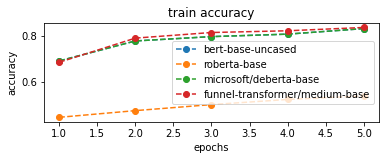

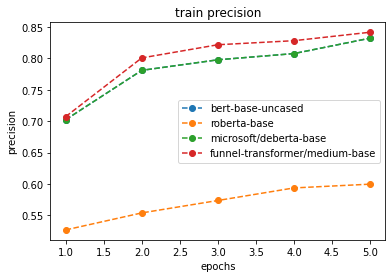

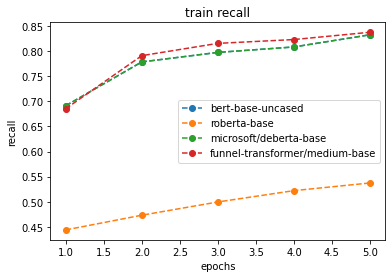

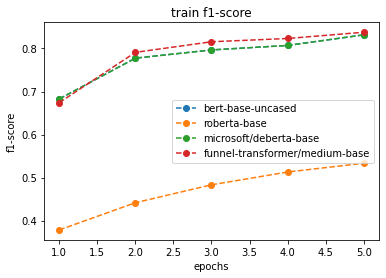

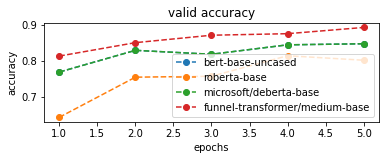

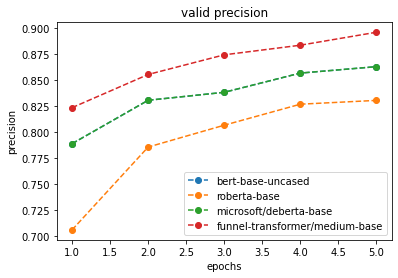

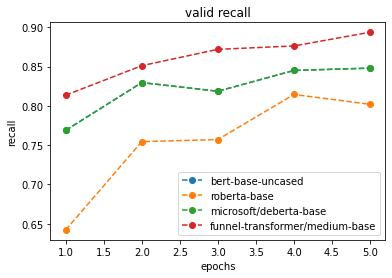

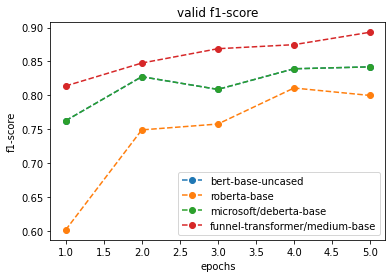

In [ ]:
plot_results(report, stages, metrics, model_names)